# Gread vs Random Search - Hyperparameter Tuning

Hyperparameter tuning is a powerful tool to enhance your supervised learning model s— improving accuracy, precision, and other important metrics by searching the optimal model parameters based on different scoring methods. There are two main options available from sklearn: **GridSearchCV** and **RandomSearchCV**

The Model hyperparameters are set by the data scientist ahead of training and control implementation aspects of the model. Hyperparameters can be thought of as model settings. These settings need to be tuned because the ideal settings for one data set will not be the same across all data sets. When tuning the hyperparameters of an estimator, Grid Search and Random Search are both popular methods.

### Grid Search

Grid Search can be thought of as an exhaustive search for selecting a model. In Grid Search, the data scientist sets up a grid of hyperparameter values and for each combination, trains a model and scores on the testing data. In this approach, every combination of hyperparameter values is tried which can be very inefficient. For example, searching 20 different parameter values for each of 4 parameters will require 160,000 trials of cross-validation. This equates to 1,600,000 model fits and 1,600,000 predictions if 10-fold cross validation is used. While Scikit Learn offers the GridSearchCV function to simplify the process, it would be an extremely costly execution both in computing power and time.

One of the major drawbacks of grid search is that when it comes to dimensionality, it suffers when the number of hyperparameters grows exponentially. With as few as four parameters this problem can become impractical, because the number of evaluations required for this strategy increases exponentially with each additional parameter, due to the curse of dimensionality.

### Random Search

By contrast, Random Search sets up a grid of hyperparameter values and selects random combinations to train the model and score. This allows you to explicitly control the number of parameter combinations that are attempted. The number of search iterations is set based on time or resources. Scikit Learn offers the RandomizedSearchCV function for this process.

While it’s possible that RandomizedSearchCV will not find as accurate of a result as GridSearchCV, it surprisingly picks the best result more often than not and in a fraction of the time it takes GridSearchCV would have taken. Given the same resources, Randomized Search can even outperform Grid Search. This can be visualized in the graphic below when continuous parameters are used.

The main difference between the pratical implementation of the two methods is that we can use n_iter to specify how many parameter values we want to sample and test.

There is an obvious trade-off between n_iter and the running time, but (depending on how many possible values you are passing) it is recommended to set n_iter to at least 100 so we can have a higher confidence in the results of the algorithm.

![title](img/Gread_Random_Srearch.png)

### In conclusion
If you have a small combination of parameters, but with large sets of possible values — along with a model that uses a lot processing time — then RandomSearchCV will save you a lot of time, while still giving you a good estimation of the optimal parameters.
Furthermore, you can use the results of the model to run RandomSearchCV again but now with a smaller set of possible values: or better yet, run GridSearchCV on the small set of possible values after having a rough idea of where the optimal parameter is with RandomSearchCV!
If your model does not take a lot of time to train, or if you already have a rough idea of where the optimal values are (due to inference, or theoretical knowledge), you should definitely use GridSearchCV as it will give you 100% certainty about which parameters you passed that produce the optimal model results.


### Implementation in Python Sklearn

Here is a simple implementation of those two methods explained above in Python Sklearn using Titanic dataset.

In [1]:
# Read files
#import os

# Data wrangling and data visualisation 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix

# Others
import time
#import warnings
#warnings.filterwarnings("ignore")

### Import and Load Data

In [2]:
# Read data from the file
data = pd.read_csv("Titanic_train.csv")
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### Feature engineering and preprocessing

- Fill missing data in the **Age** column with average age
- Combine **SibSp** and **Parch** features into a single feature: **family_size**
- Create indicator for missing data in the **Cabin** column: **cabin_missing**
- Encode the **Sex** column by assigning 0: male and 1: female
- Drop **SibSp, Parch, PassengerId, Cabin, Embarked, Name** and **Ticket** columns
- Train test split (80% training set and 20% test set)

In [3]:
# Missing data 
total = len(data)
missing_data = data.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data
pd.DataFrame({"# Missing": missing_data, "% Missing": round(missing_data / len(data) * 100, 2)})

,# Missing,% Missing
Age,177,19.87
Cabin,687,77.10
Embarked,2,0.22


In [4]:
# Fill missing data in Age column
data['Age'].fillna(data['Age'].mean(), inplace = True)

In [5]:
# Missing data 
total = len(data)
missing_data = data.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data
pd.DataFrame({"# Missing": missing_data, "% Missing": round(missing_data / len(data) * 100, 2)})

,# Missing,% Missing
Cabin,687,77.10
Embarked,2,0.22


<Figure size 432x288 with 0 Axes>

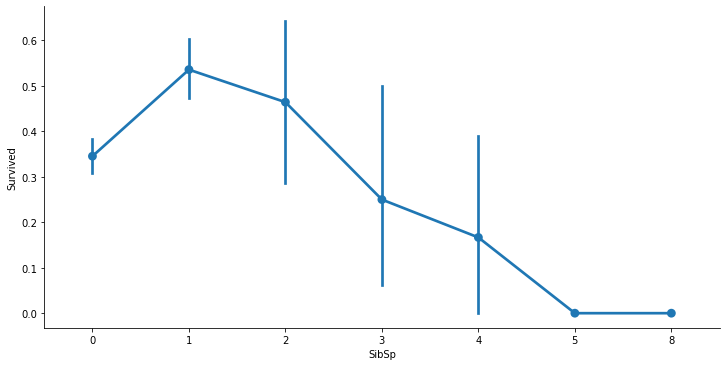

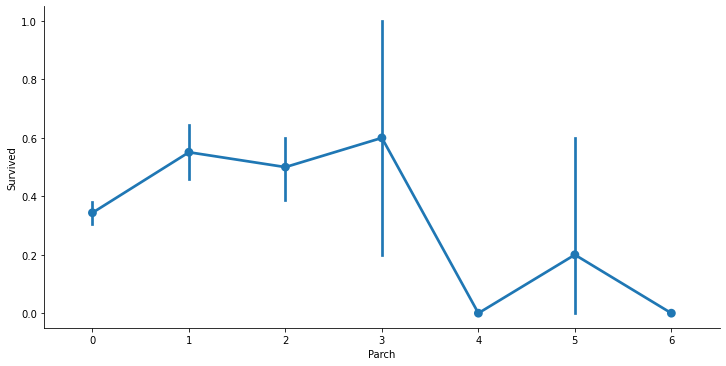

In [6]:
# Survival probability by SibSp and Parch 
# SibSp is the number of siblings or spouse of a person onboard.
# SibSp is the number of parents or children each passenger was touring with
for i, col in enumerate(['SibSp', 'Parch']):
    plt.figure(i)
    sns.catplot(x = col, y = 'Survived', data = data, kind = 'point', aspect = 2)

In [7]:
# Combine SibSp and Parch into a single feature family_size 
data['family_size'] = data['SibSp'] + data['Parch']
data[['SibSp', 'Parch', 'family_size']].head(10)

,SibSp,Parch,family_size
0,1,0,1
1,1,0,1
2,0,0,0
3,1,0,1
4,0,0,0
5,0,0,0
6,0,0,0
7,3,1,4
8,0,2,2
9,1,0,1


To prevent multicollinearity issues, we need to remove SibSp and Parch features.

In [8]:
# Drop SibSp, Parch and PassengerId features
data = data.drop(['SibSp', 'Parch', 'PassengerId'], axis = 1)
data.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,family_size
0,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,0


In [9]:
# 1: Cabin is missing, 0: Cabin is not missing 
data['cabin_missing'] = np.where(data['Cabin'].isnull(), 1, 0)
data[['Cabin', 'cabin_missing']].head()

,Cabin,cabin_missing
0,NaN,1
1,C85,0
2,NaN,1
3,C123,0
4,NaN,1


In [10]:
# Encode Sex 0: male, 1: female
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
data.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,family_size,cabin_missing
0,0,3,"Braund, Mr. Owen Harris",0,22.0,A/5 21171,7.2500,NaN,S,1,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,PC 17599,71.2833,C85,C,1,0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,113803,53.1000,C123,S,1,0
4,0,3,"Allen, Mr. William Henry",0,35.0,373450,8.0500,NaN,S,0,1


In [11]:
# Drop Cabin, Embarked, Name and Ticket columns
data = data.drop(['Cabin', 'Embarked', 'Name', 'Ticket'], axis = 1)
data.head()

,Survived,Pclass,Sex,Age,Fare,family_size,cabin_missing
0,0,3,0,22.0,7.2500,1,1
1,1,1,1,38.0,71.2833,1,0
2,1,3,1,26.0,7.9250,0,1
3,1,1,1,35.0,53.1000,1,0
4,0,3,0,35.0,8.0500,0,1


In [12]:
# Separate features and target variables
features = data.drop('Survived', axis = 1)
target = data['Survived']

# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)

# Check shape (rows, columns)
print(f"Original data: {data.shape}")
print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"Y_test: {Y_test.shape}")

Original data: (891, 7)
X_train: (712, 6)
Y_train: (712,)
X_test: (179, 6)
Y_test: (179,)


### Random Forest

Default hyperparameters for RandomForestClassifier 

`RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
)`

In [13]:
# RandomizedSearchCV for RandomForestClassifier
rf = RandomForestClassifier(n_jobs = -1, random_state = 10)
params = {
            'n_estimators': [5, 10, 50, 100, 250],
            'max_depth': [2, 4, 8, 16, 32, None],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'bootstrap' : [True, False]
        }

# Random search of parameters, using 5 fold cross validation, 

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = params, n_iter = 100, cv = 5, verbose=2, n_jobs = -1)
# Fit the random search model
start = time.time()
rf_random.fit(X_train, Y_train)
end = time.time()
rs_fit_time = end - start

print(f"Fit time: {round(rs_fit_time, 3)}")
pd.DataFrame(rf_random.cv_results_).sort_values('mean_test_score', ascending = False).head()

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fit time: 39.09


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
85,0.101001,0.040503,0.043204,0.007858,10,5,4,32,True,"{'n_estimators': 10, 'min_samples_split': 5, '...",0.811189,0.839161,0.838028,0.838028,0.838028,0.832887,0.010858,1
9,0.245403,0.026219,0.119003,0.046143,50,2,2,32,False,"{'n_estimators': 50, 'min_samples_split': 2, '...",0.839161,0.818182,0.816901,0.830986,0.845070,0.830060,0.011165,2
73,0.256805,0.032909,0.059601,0.009178,50,10,1,32,True,"{'n_estimators': 50, 'min_samples_split': 10, ...",0.832168,0.839161,0.809859,0.823944,0.845070,0.830040,0.012313,3
41,0.309205,0.025436,0.096602,0.020245,50,10,1,None,True,"{'n_estimators': 50, 'min_samples_split': 10, ...",0.832168,0.839161,0.809859,0.823944,0.845070,0.830040,0.012313,3
59,0.068000,0.015114,0.040001,0.005692,10,5,2,16,False,"{'n_estimators': 10, 'min_samples_split': 5, '...",0.832168,0.818182,0.809859,0.838028,0.845070,0.828661,0.012905,5


In [14]:
# Best hyperparameters for RandomForestClassifier 
rf_random.best_params_

{'n_estimators': 10,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_depth': 32,
 'bootstrap': True}

In [15]:
# Instantiate RandomForestClassifier with best hyperparameters 
rf = RandomForestClassifier(n_estimators = 10,
                            min_samples_split = 5,
                            min_samples_leaf = 4,
                            max_depth = 32,
                            bootstrap = True,
                            n_jobs = -1,
                            random_state = 42)

# Fit model
start = time.time()
rf_model = rf.fit(X_train, Y_train)
end = time.time()
fit_time = end - start

# Predict 
start = time.time()
Y_pred = rf_model.predict(X_test)
end = time.time()
pred_time = end - start

# Time and prediction results
precision, recall, fscore, support = score(Y_test, Y_pred, average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==Y_test).sum() / len(Y_pred), 3)}")

Fit time: 0.029 / Predict time: 0.009
Precision: 0.812 / Recall: 0.703 / Accuracy: 0.81


<AxesSubplot:>

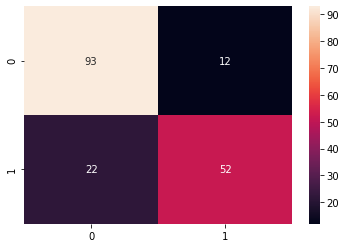

In [16]:
# Confusion matrix for RandomForestClassifier
matrix = confusion_matrix(Y_test, Y_pred)
sns.heatmap(matrix, annot = True, fmt = 'd')

In [17]:
# GridSearchCV for RandomForestClassifier
rf = RandomForestClassifier(n_jobs = -1, random_state = 10)
params = {
            'n_estimators': [5, 10, 50, 100, 250],
            'max_depth': [2, 4, 8, 16, 32, None],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'bootstrap' : [True, False]
        }

cv = GridSearchCV(rf, params, cv = 5, verbose=2, n_jobs = -1)

start = time.time()
cv.fit(X_train, Y_train)
end = time.time()
gs_fit_time = end - start
print(f"Fit time: {round(gs_fit_time, 3)}")

pd.DataFrame(cv.cv_results_).sort_values('mean_test_score', ascending = False).head()

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Fit time: 155.76


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
132,0.333675,0.056788,0.051201,0.011126,True,8,4,10,50,"{'bootstrap': True, 'max_depth': 8, 'min_sampl...",0.832168,0.846154,0.816901,0.838028,0.838028,0.834256,0.009753,1
216,0.075001,0.013814,0.035402,0.012532,True,32,4,5,10,"{'bootstrap': True, 'max_depth': 32, 'min_samp...",0.811189,0.839161,0.838028,0.838028,0.838028,0.832887,0.010858,2
166,0.103802,0.027616,0.058601,0.016812,True,16,4,2,10,"{'bootstrap': True, 'max_depth': 16, 'min_samp...",0.811189,0.839161,0.838028,0.838028,0.838028,0.832887,0.010858,2
256,0.087402,0.011128,0.051401,0.011791,True,None,4,2,10,"{'bootstrap': True, 'max_depth': None, 'min_sa...",0.811189,0.839161,0.838028,0.838028,0.838028,0.832887,0.010858,2
211,0.069001,0.005060,0.030601,0.006590,True,32,4,2,10,"{'bootstrap': True, 'max_depth': 32, 'min_samp...",0.811189,0.839161,0.838028,0.838028,0.838028,0.832887,0.010858,2


In [18]:
# Best hyperparameters for RandomForestClassifier 
cv.best_params_

{'bootstrap': True,
 'max_depth': 8,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 50}

In [19]:
# Instantiate RandomForestClassifier with best hyperparameters 
rf = RandomForestClassifier(n_estimators = 50,
                            min_samples_split = 10,
                            min_samples_leaf = 4,
                            max_depth = 8,
                            bootstrap = True,
                            n_jobs = -1,
                            random_state = 42)

# Fit model
start = time.time()
rf_model = rf.fit(X_train, Y_train)
end = time.time()
fit_time = end - start

# Predict 
start = time.time()
Y_pred = rf_model.predict(X_test)
end = time.time()
pred_time = end - start

# Time and prediction results
precision, recall, fscore, support = score(Y_test, Y_pred, average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==Y_test).sum() / len(Y_pred), 3)}")

Fit time: 0.121 / Predict time: 0.017
Precision: 0.833 / Recall: 0.676 / Accuracy: 0.81


<AxesSubplot:>

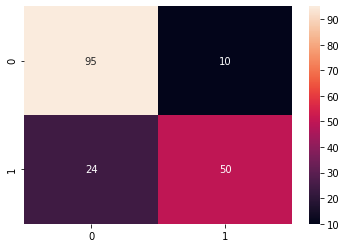

In [20]:
# Confusion matrix for RandomForestClassifier
matrix = confusion_matrix(Y_test, Y_pred)
sns.heatmap(matrix, annot = True, fmt = 'd')

### Gradient Boosting

Default hyperparameters for GradientBoostingClassifier

`GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)`

In [21]:
# RandomizedSearchCV for RandomForestClassifier
gb = GradientBoostingClassifier(random_state = 10)
params = {
            'n_estimators': [5, 10, 50, 100, 250],
            'max_depth': [2, 4, 8, 16, 32, None],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'learning_rate': [0.01, 0.05, 0.1]
        }

# Random search of parameters, using 5 fold cross validation, 

gb_random = RandomizedSearchCV(estimator = gb, param_distributions = params, n_iter = 100, cv = 5, verbose=2, n_jobs = -1)
# Fit the random search model
start = time.time()
gb_random.fit(X_train, Y_train)
end = time.time()
gb_fit_time = end - start

print(f"Fit time: {round(gb_fit_time, 3)}")
pd.DataFrame(rf_random.cv_results_).sort_values('mean_test_score', ascending = False).head()

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fit time: 58.359


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
85,0.101001,0.040503,0.043204,0.007858,10,5,4,32,True,"{'n_estimators': 10, 'min_samples_split': 5, '...",0.811189,0.839161,0.838028,0.838028,0.838028,0.832887,0.010858,1
9,0.245403,0.026219,0.119003,0.046143,50,2,2,32,False,"{'n_estimators': 50, 'min_samples_split': 2, '...",0.839161,0.818182,0.816901,0.830986,0.845070,0.830060,0.011165,2
73,0.256805,0.032909,0.059601,0.009178,50,10,1,32,True,"{'n_estimators': 50, 'min_samples_split': 10, ...",0.832168,0.839161,0.809859,0.823944,0.845070,0.830040,0.012313,3
41,0.309205,0.025436,0.096602,0.020245,50,10,1,None,True,"{'n_estimators': 50, 'min_samples_split': 10, ...",0.832168,0.839161,0.809859,0.823944,0.845070,0.830040,0.012313,3
59,0.068000,0.015114,0.040001,0.005692,10,5,2,16,False,"{'n_estimators': 10, 'min_samples_split': 5, '...",0.832168,0.818182,0.809859,0.838028,0.845070,0.828661,0.012905,5


In [22]:
# Best hyperparameters for RandomForestClassifier 
gb_random.best_params_

{'n_estimators': 250,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': 4,
 'learning_rate': 0.01}

In [23]:
# Instantiate RandomForestClassifier with best hyperparameters 
rf = GradientBoostingClassifier(n_estimators = 250,
                                learning_rate = 0.01,
                                min_samples_split = 5,
                                min_samples_leaf = 2,
                                max_depth = 4,
                                random_state = 42)

# Fit model
start = time.time()
rf_model = rf.fit(X_train, Y_train)
end = time.time()
fit_time = end - start

# Predict 
start = time.time()
Y_pred = rf_model.predict(X_test)
end = time.time()
pred_time = end - start

# Time and prediction results
precision, recall, fscore, support = score(Y_test, Y_pred, average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==Y_test).sum() / len(Y_pred), 3)}")

Fit time: 0.308 / Predict time: 0.002
Precision: 0.841 / Recall: 0.716 / Accuracy: 0.827


<AxesSubplot:>

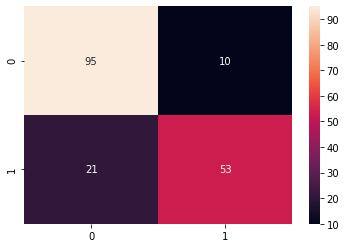

In [24]:
# Confusion matrix for GradientBoostingClassifier
matrix = confusion_matrix(Y_test, Y_pred)
sns.heatmap(matrix, annot = True, fmt = 'd')

In [25]:
# GridSearchCV for GradientBoostingClassifier 
gb = GradientBoostingClassifier(random_state = 10)
params = {
            'n_estimators': [5, 10, 50, 100, 250],
            'max_depth': [2, 4, 8, 16, 32, None],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'learning_rate': [0.01, 0.05, 0.1]
        }

cv = GridSearchCV(gb, params, cv = 5, verbose=2, n_jobs = -1)

start = time.time()
cv.fit(X_train, Y_train)
end = time.time()
gs_fit_time = end - start
print(f"Fit time: {round(gs_fit_time, 3)}")

pd.DataFrame(cv.cv_results_).sort_values('mean_test_score', ascending = False).head()

Fitting 5 folds for each of 810 candidates, totalling 4050 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
69,0.785014,0.056717,0.005800,0.000400,0.01,4,2,5,250,"{'learning_rate': 0.01, 'max_depth': 4, 'min_s...",0.832168,0.860140,0.809859,0.84507,0.845070,0.838462,0.016823,1
64,0.805014,0.061033,0.006600,0.000800,0.01,4,2,2,250,"{'learning_rate': 0.01, 'max_depth': 4, 'min_s...",0.832168,0.860140,0.809859,0.84507,0.845070,0.838462,0.016823,1
59,0.640812,0.029288,0.006399,0.000489,0.01,4,1,10,250,"{'learning_rate': 0.01, 'max_depth': 4, 'min_s...",0.839161,0.846154,0.809859,0.84507,0.845070,0.837063,0.013823,3
74,0.683813,0.013789,0.006599,0.000799,0.01,4,2,10,250,"{'learning_rate': 0.01, 'max_depth': 4, 'min_s...",0.832168,0.860140,0.809859,0.84507,0.838028,0.837053,0.016502,4
337,0.145602,0.007228,0.011401,0.008090,0.05,4,2,5,50,"{'learning_rate': 0.05, 'max_depth': 4, 'min_s...",0.832168,0.860140,0.809859,0.84507,0.838028,0.837053,0.016502,4


In [26]:
# Best hyperparameters for GradientBoostingClassifier 
cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 250}

In [27]:
# Random Forest Time and prediction results
print("Random Forest Time and prediction results")
precision, recall, fscore, support = score(Y_test, Y_pred, average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==Y_test).sum() / len(Y_pred), 3)}")
print("-------------------------------------------------------------------------")

# Instantiate GradientBoostingClassifier with best hyperparameters 
rf = GradientBoostingClassifier(n_estimators = 250,
                                max_depth = 4,
                                learning_rate = 0.01,
                                min_samples_leaf = 2,
                                min_samples_split = 2,
                                random_state = 42)

# Fit model
start = time.time()
rf_model = rf.fit(X_train, Y_train)
end = time.time()
fit_time = end - start

# Predict 
start = time.time()
Y_pred = rf_model.predict(X_test)
end = time.time()
pred_time = end - start

# GradientBoosting Time and prediction results
print("GradientBoosting Time and prediction results")
precision, recall, fscore, support = score(Y_test, Y_pred, average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==Y_test).sum() / len(Y_pred), 5)}")

Random Forest Time and prediction results
Fit time: 0.308 / Predict time: 0.002
Precision: 0.841 / Recall: 0.716 / Accuracy: 0.827
-------------------------------------------------------------------------
GradientBoosting Time and prediction results
Fit time: 0.316 / Predict time: 0.003
Precision: 0.841 / Recall: 0.716 / Accuracy: 0.82682


In [ ]:
# Confusion matrix for GradientBoostingClassifier
matrix = confusion_matrix(Y_test, Y_pred)
sns.heatmap(matrix, annot = True, fmt = 'd')